## Copy this notebook (if using Colab) via `File -> Save a Copy in Drive`.

## You can do this assignment outside of Colab (using your local Python installation) via `File -> Download`.

## <u>**Use the "Text" blocks to provide explanations wherever you find them necessary. Highlight your answers inside these text fields to ensure that we don't miss it while grading your HW.**</u>

## *Please answer questions within their designated section and in the order they are asked to maintain clarity and organization. You can add new code and text blocks if you want.*

## **Setup** 🔧

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and uploading it to your drive), you can skip this section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# First mount your drive before running these cells.
# Create a folder for the this HW and change to that dir
%cd drive/MyDrive/masters/CSE519/519_hw2

/content/drive/MyDrive/masters/CSE519/519_hw2


# Download data from Kaggle 📥

In [ ]:
!pip install -q kaggle

In [ ]:
# Go to your Kaggle account and navigate to your account settings (click on your profile picture -> "Account").
# Scroll down to the "API" section and click "Create New API Token." This will download a kaggle.json file containing your API key.
# In your Colab notebook, run the following code to upload the kaggle.json file
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c zillow-prize-1

# Alternate: download data using gdown (if having issues with Kaggle) 📁

In [ ]:
! pip install gdown

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=15Ap7c-LehMzMYpv3WIWbja1Mns_BTYgQ'
gdown.download(url)

# Extract data and install packages (regardless of data acquisition method) 🚀

In [ ]:
!unzip zillow-prize-1.zip

In [ ]:
### TODO: Install required packages
### Student's code here
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn
### END
!pip install folium

## **Library and Data Imports**
- Import your libraries and the data here

In [ ]:
### TODO: Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
###

In [ ]:

properties_2016 = pd.read_csv('properties_2016.csv')

missing_percentage = properties_2016.isnull().mean() * 100

# Determine which columns have more than 20% of data missing. If this is the case, we drop the column
columns_to_drop = missing_percentage[missing_percentage > 20].index
properties_2016_cleaned = properties_2016.drop(columns=columns_to_drop)

# After some manual confirmation the latitude and the longitude seem to be multiplied by a million in the initial database to avoid decimals.
properties_2016_cleaned['latitude'] = properties_2016_cleaned['latitude'] / 1000000
properties_2016_cleaned['longitude'] = properties_2016_cleaned['longitude'] / 1000000

# Drop null data because we have an abundance of data
properties_2016_cleaned = properties_2016_cleaned.dropna()

# Randomly sample 1000 properties so our code runs faster
properties_2016_cleaned = properties_2016_cleaned.sample(n=1000, random_state=42)




<ipython-input-4-270d4e9cfa8b>:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2016 = pd.read_csv('properties_2016.csv')


I perform some pre processing from what I noticed initially when looking at the data set and I saw a lot of places with emptyish cells. I simply just drop them for the first couple of problems but later on I deal with them better.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize all of the columns that need it
def scale_features(df, column):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[column])
    return df

columns_to_normalize = [
    'calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt',
    'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt'
]

properties_2016_normalized = scale_features(properties_2016_cleaned, columns_to_normalize)

We need to normalize the data on features that are numeric or some values will dominate others.

## **Q1: House Desirability Scoring and Ranking (10 Points)**


In [ ]:
def desirability_score(row):
    # Weights that I manually thought were important
    size_weight = 0.25
    bathroom_weight = 0.15
    bedroom_weight = 0.20
    lot_size_weight = 0.15
    year_built_weight = 0.10
    tax_value_weight = 0.15

    # I thought size mattered the most, then bedrooms should have a slightly higher value than bathrooms.
    # I think the lot_size has similar weight to the size, but we already have the total square feet so I decreased it a abit.
    # The year built in my experience does matter but renovation do happen so I think this matters the least
    # Tax value is generally a representation of property value, those that have higher taxes should have a higher property value

    normalized_size = row['calculatedfinishedsquarefeet']
    normalized_bathrooms = row['bathroomcnt']
    normalized_bedrooms = row['bedroomcnt']
    normalized_lot_size = row['lotsizesquarefeet']
    normalized_year_built = row['yearbuilt']
    normalized_tax_value = row['taxvaluedollarcnt']

    # Desirability Score after summing up the weights
    return (size_weight * normalized_size +
            bathroom_weight * normalized_bathrooms +
            bedroom_weight * normalized_bedrooms +
            lot_size_weight * normalized_lot_size +
            year_built_weight * normalized_year_built +
            tax_value_weight * normalized_tax_value)

# Generate the desirability scores
properties_2016_normalized['desirability_score'] = properties_2016_normalized.apply(desirability_score, axis=1)

# Get the top and bottom 10 most and least desirable houses
top_10_desirable = properties_2016_normalized.nlargest(10, 'desirability_score')
bottom_10_desirable = properties_2016_normalized.nsmallest(10, 'desirability_score')

# Output results
print("Top 10 desirable houses:\n", top_10_desirable)
print("\nBottom 10 desirable houses:\n", bottom_10_desirable)
# Note that these results are normalized

# This gets a specific one (the top parcelid) to observe the non normalized data
print(properties_2016[properties_2016['parcelid'] == 11655183])

# These are from the top and the lowest
max_desireability_difference = 0.744131 - 0.034244


Top 10 desirable houses:
          parcelid  bathroomcnt  bedroomcnt  calculatedbathnbr  \
2264885  11655183       0.8750         0.5                8.0   
1557276  13889919       1.0000         0.8                9.0   
2958214  11684421       0.7500         0.5                7.0   
391167   11661314       1.0000         0.7                9.0   
2675727  12702079       0.8750         0.5                8.0   
522305   10869419       0.8750         0.5                8.0   
2294495  11692647       0.7500         0.7                7.0   
741237   14410905       0.5625         0.5                5.5   
1142429  14324396       0.4375         0.4                4.5   
2625861  12832300       0.7500         0.5                7.0   

         calculatedfinishedsquarefeet  finishedsquarefeet12    fips  \
2264885                      1.000000               10256.0  6037.0   
1557276                      0.874949                9032.0  6059.0   
2958214                      0.824785        

## **Q2: Pairwise Distance Function for Property Similarity (10 Points)**


In [ ]:
from geopy.distance import geodesic

# I got the max_property_distance manually
# I looked at the map and picked the two farthest apart that looked good because I didnt want to go through a double for loop
# of millions of rows. I looked at the cities and searched up the distance in miles for google.
def pairwise_distance(property1, property2, max_geo_distance = 142, max_property_distance = 0.709887):
    # calculate the differences by using an library to find the miles
    geo_distance = geodesic(
        (property1['latitude'], property1['longitude']),
        (property2['latitude'], property2['longitude'])
    ).miles

    # I used my desireability score function from above to calculate the differences
    property_features1 = desirability_score(property1)
    property_features2 = desirability_score(property2)
    property_distance = abs(property_features1 - property_features2)

    normalized_geo_distance = geo_distance/max_geo_distance
    normalized_property_distance = property_distance/max_property_distance


    # I would argue that the location has a big importance so I used 50/50 to balance the two
    # distances that I found
    total_distance = 0.5 * normalized_geo_distance + 0.5 * normalized_property_distance
    return total_distance


## **Q3: Clustering Properties Using Distance Metrics (15 Points)**


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.impute import SimpleImputer


# Create a distance matrix for the houses
n = len(properties_2016_normalized)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        distance_matrix[i][j] = pairwise_distance(properties_2016_normalized.iloc[i], properties_2016_normalized.iloc[j])
        distance_matrix[j][i] = distance_matrix[i][j]

# replace any nans with max
imputer = SimpleImputer(strategy='constant', fill_value=np.nanmax(distance_matrix))
distance_matrix = imputer.fit_transform(distance_matrix)


In [ ]:
# Following the example given from piazza and DBSCAN, I did have to decrease my eps by quite a bit to get meaningful clusters.
# The eps was found by trial and error of me trying different numbers
# I also increased min_samples by trial and error
dbscan = DBSCAN(eps=0.02, min_samples=10, metric='precomputed')
labels = dbscan.fit_predict(distance_matrix)

clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(properties_2016_normalized.iloc[i]['parcelid'])

for label, members in clusters.items():
    print(f'Cluster {label}: {members}')

Cluster 4: [11416257, 11940065, 11695704, 11965756, 11791086, 12286082, 12270884, 12221073, 12198634, 11817435, 12068930, 12365204, 11958423, 12221088, 11971623, 11818625, 12364331, 12060756, 11791494, 11788259, 12270963, 11820319, 11719435, 11977398, 11957356, 11794673, 11802987, 11730793, 11769913, 11722714, 11390991, 12356651, 12240221, 12272782, 11979312, 12087885, 11786349, 12309355, 12010868, 12191798]
Cluster -1: [11072267, 13060099, 13080687, 17270807, 14479531, 12525885, 13984611, 11104162, 12972101, 11109105, 10723199, 11266840, 14351558, 17182182, 12059798, 11458366, 14175468, 12606821, 13979618, 12567862, 17230060, 14087395, 14384570, 14457961, 17091473, 14425096, 11284474, 11893756, 12931022, 11227901, 14098216, 12111805, 13081591, 14244469, 14200405, 10724543, 17142171, 14165956, 17208286, 11553934, 14336194, 17140526, 12159681, 12812548, 12863339, 12967213, 14298108, 11160032, 11498755, 17226915, 10778004, 12655766, 13966994, 11502180, 12170410, 11609931, 13061135, 11174

In [ ]:
import folium
from folium.plugins import MarkerCluster

# set the center to the mean
map_center = [properties_2016_normalized['latitude'].mean(), properties_2016_normalized['longitude'].mean()]
map_clusters = folium.Map(location=map_center, zoom_start=10)

colors = sns.color_palette('Set1', len(set(labels))).as_hex()

marker_cluster = MarkerCluster().add_to(map_clusters)

for i, label in enumerate(labels):
    # -1 clusters represent noise so we skip those
    if label != -1:
        lat = properties_2016_normalized.iloc[i]['latitude']
        lon = properties_2016_normalized.iloc[i]['longitude']
        cluster_color = colors[label]

        # Color code based off of the cluster and use a index in the colors set above
        folium.Marker(
            location=[lat, lon],
            popup=f"Cluster: {label}",
            icon=folium.Icon(color="white", icon="info-sign", icon_color=cluster_color)  # Use cluster color for icon
        ).add_to(marker_cluster)



from IPython.display import display
display(map_clusters)


In [ ]:
# Display non-NaN values for the specified parcel IDs
parcelid_1 = properties_2016[properties_2016['parcelid'] == 11416257].dropna(axis=1, how='all')
parcelid_2 = properties_2016[properties_2016['parcelid'] == 11940065].dropna(axis=1, how='all')

print(parcelid_1)
print(parcelid_2)


         parcelid  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
2456979  11416257          1.0         2.0                    7.0   

         calculatedbathnbr  calculatedfinishedsquarefeet  \
2456979                1.0                        1140.0   

         finishedsquarefeet12    fips  fullbathcnt  heatingorsystemtypeid  \
2456979                1140.0  6037.0          1.0                    7.0   

         ...  regionidzip  roomcnt  unitcnt yearbuilt  \
2456979  ...      96136.0      0.0      1.0    1927.0   

         structuretaxvaluedollarcnt taxvaluedollarcnt  assessmentyear  \
2456979                     33786.0          126725.0          2015.0   

         landtaxvaluedollarcnt  taxamount  censustractandblock  
2456979                92939.0    2215.24         6.037602e+13  

[1 rows x 29 columns]
        parcelid  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
302819  11940065          1.0         2.0                    7.0   

        calculatedbathnbr  calcul

I plotted the clusters on a map to provide a better visualization of where they are grouped. I have experience with map software as a result of my class in 416 so I was aware of Folium and I used it to display these clusters.

I noted that these clusters were prominently grouped by location. Clusters that were close to each other geographically were the same color.

Then I noticed that my form of distance was wrong as the distance in miles would be much larger than my desireability score so I had to normalize my data and recalculate my clusters.

After doing that, I noticed much better clustering where locations did have some common colors but there were varietys found. I took two parcel ids and printed the data and observed a lot of similar and close data (same bathroom, bedroom count etc).

## **Q4: Integrating External Data for Price Prediction (15 Points)**


https://hdpulse.nimhd.nih.gov/data-portal/social/table?socialtopic=030&socialtopic_options=social_6&demo=00011&demo_options=income_3&race=00&race_options=race_7&sex=0&sex_options=sexboth_1&age=001&age_options=ageall_1&statefips=06&statefips_options=area_states

I got the income information based off of counties here and I exported as a csv and did minor adjustments to make it a proper csv file.

In [ ]:
import requests

def get_county_from_lat_lon(lat, lon):
  url = f"https://geo.fcc.gov/api/census/area?lat={lat}&lon={lon}&format=json"

  try:
    response = requests.get(url)
    data = response.json()

    if 'results' in data and len(data['results']) > 0:
      return data['results'][0]['county_name']
    else:
      print("NO COUNTY FOUND")
      return None
  except Exception as e:
    print("ERROR")
    return None

county = get_county_from_lat_lon(33.94, -116.28)
print(county)


Riverside County


In [ ]:
county_income = pd.read_csv('HDPulse_data_export.csv')
county_income_dict = dict(zip(county_income['County'], county_income['Value (Dollars)']))

county = 'Trinity County'
print(county)
print(county_income_dict[county])


Trinity County
47,317


I chose arrest data as the external dataset because I believe crime rates are a major factor in buying a home. When people choose to buy homes, they want the area to be safe regardless of whether or not they have children. I acknowledge that education is also a main factor when deciding

After hearing Professor mention income levels, I decided to use that as a metric as it is much simpler than using arrest data. I was having a lot of issues with arrest data but I am deciding to now use income by countys. I am using an API query to get information based off of latitude and longitude where a house is.

Later I don't use this API anymore because it takes way too long to run on millions of rows.

The main importance of income is houses are typically better in locations with higher incomes, as they can afford better houses. More money means better house.

## **Q5: Visualizing Insights from Housing Data (15 Points)**


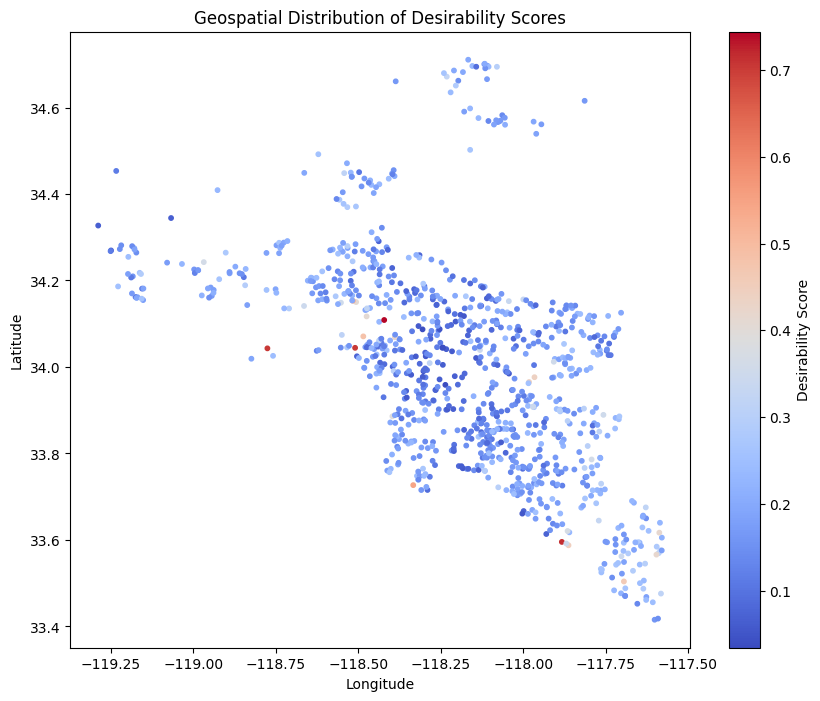

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))

# Create a scatter plot with a colormap
sc = plt.scatter(properties_2016_normalized['longitude'], properties_2016_normalized['latitude'],
                 c=properties_2016_normalized['desirability_score'], cmap='coolwarm', s=10)

# Add a color bar to better visualize which are more desireable
plt.colorbar(sc, label='Desirability Score')

plt.title('Geospatial Distribution of Desirability Scores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



plt.figure(figsize=(10, 8))


This figure gives me information about a houses desireability as well as their Longitude and Latitude. I noticed that a lot of houses with high desireability were near the water which makes sense, as these houses are generally more expensive as they are closer to the water. I also noticed that a lot of the houses that are higher desireable are closer to each other in patches. There are clearly some areas with darker blue dots and other places are lighter blue, which also makes sense as houses that are more expensive will probably be around other houses that are more expensive (and vice versa).

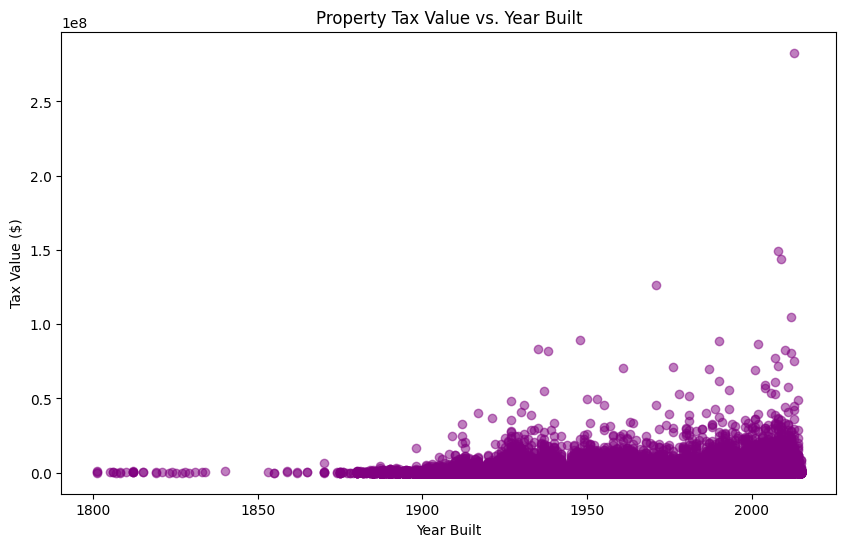

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(properties_2016['yearbuilt'], properties_2016['taxvaluedollarcnt'], alpha=0.5, color='purple')
plt.title('Property Tax Value vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Tax Value ($)')
plt.show()


This chart shows information about how houses tax values correlates with the year it was built. As the year built gets more closer to the present, the tax value of the property does go up. It is important to see, however, that around the 1950s and onwards there are some 'outliers' that seem to have higher tax values than the rest. However, many houses undergo renovations which increases the household property level immensely while the year it was build technically stays the same.

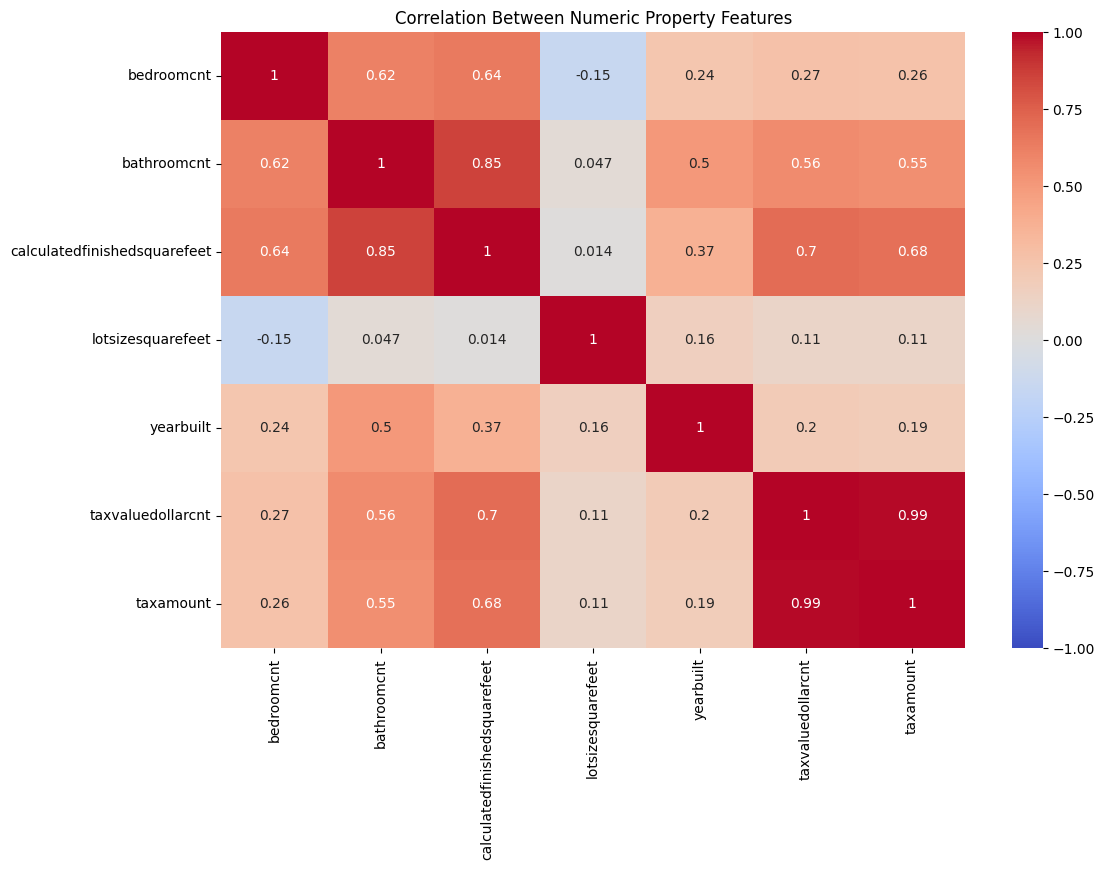

In [ ]:
plt.figure(figsize=(12, 8))
numeric_features = properties_2016_normalized[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']]
correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Numeric Property Features')
plt.show()


This shows which numeric data values are correlated. One thing that stood out to me was the year built being correlated with the bathroom count. Although it wasn't too high, the bathroom was the highest and it doesn't make too much sense to me. There are some things that do made sense like taxvaluedollarcnt being highly correlated to square feet as higher areas typically means you're paying for more land. Curiously, bathrooms were pretty up there as well.

## **Q6: Best Prediction Model for Zillow Logerror (20 Points)**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load datasets
train = pd.read_csv('train_2016_v2.csv')
properties = pd.read_csv('properties_2016.csv')

# After some manual confirmation the latitude and the longitude seem to be multiplied by a million in the initial database to avoid decimals and conflicts
# when I use income data
properties['latitude'] = properties['latitude'] / 1000000
properties['longitude'] = properties['longitude'] / 1000000

submission = pd.read_csv('sample_submission.csv')

# Read the income CSV file in case it wasn't read above and generate the dictionary
county_income = pd.read_csv('HDPulse_data_export.csv')
county_income_dict = dict(zip(county_income['County'], county_income['Value (Dollars)']))




<ipython-input-22-6bf961cfc3ad>:9: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv('properties_2016.csv')


The following is a graph that give me a visual for where to start parsing and figure out where to start dropping data that has very to low data. I worked from right to left from the most part in my data augmentation analysis

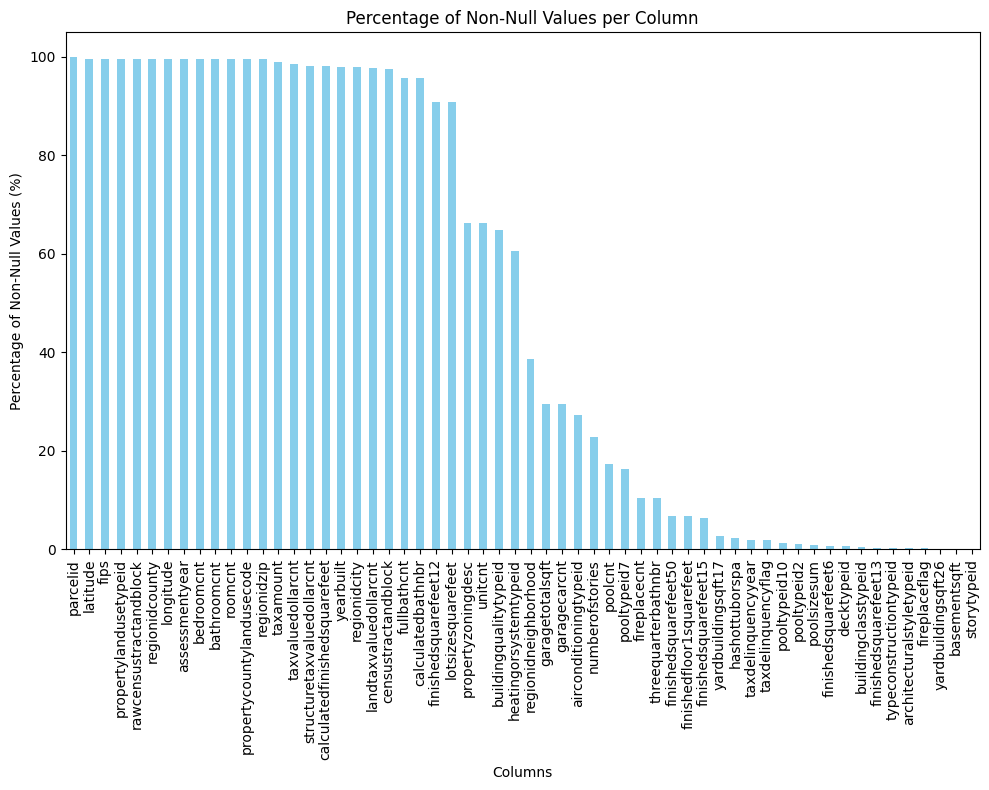

In [ ]:
import matplotlib.pyplot as plt

# Figure out what the percentage is not null in the dataset
non_null_percentage = properties.notnull().mean() * 100
non_null_percentage = non_null_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
non_null_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Non-Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Non-Null Values (%)')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

Special Cases:
Garage Data and Deck

In [ ]:
# print(properties['garagecarcnt'].notnull().sum())
# print(properties['garagetotalsqft'].notnull().sum())
# These have the same number so we can see we don't need extra processing
# Check after finding out fire place has weird issues

properties['garagecarcnt'] = properties['garagecarcnt'].fillna(0)
properties['garagetotalsqft'] = properties['garagetotalsqft'].fillna(0)

# decktypeid has only 66 for some reason and I am assuming that means there is a deck.
properties['decktypeid'] = properties['decktypeid'].fillna(0)
properties['decktypeid'] = properties['decktypeid'].apply(lambda x: 1 if x != 0 else 0)








Special Case: Fireplace

In [ ]:
# properties['fireplaceflag'] = properties['fireplaceflag'].fillna(0)

# I later realized that fireplace count has values that we need and I can't just drop it because
# for some reason fireplace count is larger than the flag.

median_fireplace_size = properties['fireplacecnt'].median()
properties.loc[properties['fireplacecnt'].notnull(), 'fireplaceflag'] = True

properties.loc[(properties['fireplaceflag'] == True) & (properties['fireplacecnt'].isnull()), 'fireplacecnt'] = median_fireplace_size


properties['fireplaceflag'] = properties['fireplaceflag'].replace(to_replace=True, value=1)
properties['fireplaceflag'] = properties['fireplaceflag'].fillna(0)
properties['fireplacecnt'] = properties['fireplacecnt'].fillna(0)




<ipython-input-25-f581a413d9c0>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  properties['fireplaceflag'] = properties['fireplaceflag'].replace(to_replace=True, value=1)


General data fillings, I realized that I didn't want to create text boxes for every data and most of the logic started being similar and blended in.

In [ ]:
# Pool processing
properties['poolcnt'] = properties['poolcnt'].fillna(0)

# Replace all with 0 and True with 1's
properties['hashottuborspa'] = properties['hashottuborspa'].fillna(0)
properties['hashottuborspa'] = properties['hashottuborspa'].replace(to_replace=True, value=1)

# Calculate the median and replace the nans
median_pool_size = properties.loc[properties.poolcnt == 1, 'poolsizesum'].median()

properties.loc[properties.poolcnt == 1, 'poolsizesum'] = properties.loc[properties.poolcnt == 1, 'poolsizesum'].fillna(median_pool_size)
properties['poolsizesum'] = np.where(properties['poolcnt'] == 0, 0, properties['poolsizesum'])


# Similar to fireplace flag
properties['taxdelinquencyflag'] = properties['taxdelinquencyflag'].replace(to_replace='Y', value=1)
properties['taxdelinquencyflag'] = properties['taxdelinquencyflag'].fillna(0)


# Information about backyard properties, I will put 0 to indicate nothing
properties['yardbuildingsqft26'] = properties['yardbuildingsqft26'].fillna(0)
properties['yardbuildingsqft17'] = properties['yardbuildingsqft17'].fillna(0)

# If null, assume no a/c which is represented by 5
properties['airconditioningtypeid'] = properties['airconditioningtypeid'].fillna(5)

# same with heating
properties['heatingorsystemtypeid'] = properties['heatingorsystemtypeid'].fillna(13)

# There has to be at least one unit for nan values
properties['unitcnt'] = properties['unitcnt'].fillna(1)

# Replace lotsize square feet with the average where it is nan
properties['lotsizesquarefeet'] = properties['lotsizesquarefeet'].fillna(properties['lotsizesquarefeet'].mean())


# Information about tax but these are separate because in some cases its possible for there to be no tax
properties['landtaxvaluedollarcnt'] = properties['landtaxvaluedollarcnt'].fillna(0)
properties['structuretaxvaluedollarcnt'] = properties['structuretaxvaluedollarcnt'].fillna(0)

# There will always be some sort of tax here so we can use the mean
properties['taxamount'] = properties['taxamount'].fillna(properties['taxamount'].mean())
properties['taxvaluedollarcnt'] = properties['taxvaluedollarcnt'].fillna(properties['taxvaluedollarcnt'].mean())

# There is a lot of information here compared to the other ids so I feel more comfortable using the mode to replace the nans
properties['propertycountylandusecode'] = properties['propertycountylandusecode'].fillna(properties['propertycountylandusecode'].mode())
properties['propertylandusetypeid'] = properties['propertylandusetypeid'].fillna(properties['propertylandusetypeid'].mode())
properties['fips'] = properties['fips'].fillna(properties['fips'].mode())

# Other things to fill with the mode

def fill_nan_with_mode(df, columns):
    for column in columns:
        if column in df.columns:
            mode_value = df[column].mode()
            df[column].fillna(mode_value[0], inplace=True)

columns = ['bedroomcnt', 'calculatedbathnbr', 'roomcnt', 'latitude', 'longitude', 'yearbuilt', 'propertycountylandusecode', 'calculatedfinishedsquarefeet']
fill_nan_with_mode(properties, columns)

# properties['bedroomcnt'] = properties['bedroomcnt'].fillna(properties['bedroomcnt'].mode())
# properties['calculatedbathnbr'] = properties['calculatedbathnbr'].fillna(properties['calculatedbathnbr'].mode())
# properties['roomcnt'] = properties['roomcnt'].fillna(properties['roomcnt'].mode())
# properties['latitude'] = properties['latitude'].fillna(properties['latitude'].mode())
# properties['longitude'] = properties['longitude'].fillna(properties['longitude'].mode())
# properties['yearbuilt'] = properties['yearbuilt'].fillna(properties['yearbuilt'].mode())
















<ipython-input-26-315ccabddc2e>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  properties['hashottuborspa'] = properties['hashottuborspa'].replace(to_replace=True, value=1)
<ipython-input-26-315ccabddc2e>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  properties['taxdelinquencyflag'] = properties['taxdelinquencyflag'].replace(to_replace='Y', value=1)
<ipython-input-26-315ccabddc2e>:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior

In [ ]:
# Merge train with properties data on 'parcelid'
train_data = pd.merge(train, properties, on='parcelid', how='left')


# The following ids are dropped because they are more descriptive IDs, and its too hard
# to guess what id they belong to. Median or any deduction techniques i can think of don't work
# They are also missing a lot of data.

# architecturalstyletypeid/storytypeid/typeconstructiontypeid/buildingclasstypeid

# caclulated finished square feet has the most rows, i don't think we need the other columns regarding square feet
# threequarterbathnbr, fullbathcnt seems redundant when we have calculatedbathnbr

# regionidzip has zip codes that don't make sense, regionidcounty falls under the same boat, regionidneighborhood/city also
# pooltypeid2/7/10 are super small, I also feel that we have enough pool data.

# taxdelinquencyyear cannot really be predicted and there isn't too much data
# basement square feet is missing too much data

# I'm not sure how to get numberofstories for places that aren't populated so we drop it
# buildingqualitytypeid im not sure what this represents so I don't want to replace it with something that is wrong
# same with propertyzoningdesc

# censustractandblock and rawcensustractandblock seem to just provide location data which is done by latitude and longitude already


columns_to_drop = [
    'architecturalstyletypeid', 'storytypeid', 'typeconstructiontypeid', 'buildingclasstypeid',
    'finishedfloor1squarefeet', 'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
    'finishedsquarefeet50', 'threequarterbathnbr', 'fullbathcnt',
    'regionidzip', 'regionidcounty', 'regionidneighborhood', 'regionidcity', 'pooltypeid2',
    'pooltypeid7', 'pooltypeid10', 'taxdelinquencyyear', 'basementsqft', 'numberofstories', 'buildingqualitytypeid',
    'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock'
]
train_data.drop(columns=columns_to_drop, inplace=True)

# I printed here to double check all of my columns are full
print(train_data.notnull().mean().sort_values(ascending = False))


parcelid                        1.0
yardbuildingsqft26              1.0
poolsizesum                     1.0
propertycountylandusecode       1.0
propertylandusetypeid           1.0
roomcnt                         1.0
unitcnt                         1.0
yardbuildingsqft17              1.0
yearbuilt                       1.0
logerror                        1.0
fireplaceflag                   1.0
structuretaxvaluedollarcnt      1.0
taxvaluedollarcnt               1.0
assessmentyear                  1.0
landtaxvaluedollarcnt           1.0
taxamount                       1.0
poolcnt                         1.0
lotsizesquarefeet               1.0
longitude                       1.0
latitude                        1.0
heatingorsystemtypeid           1.0
hashottuborspa                  1.0
garagetotalsqft                 1.0
garagecarcnt                    1.0
fireplacecnt                    1.0
fips                            1.0
calculatedfinishedsquarefeet    1.0
decktypeid                  

In [ ]:
#BEGIN[ChatGPT GPT-4][https://chat.openai.com/auth/login] I asked for python code to hack the countys in a dictionary
# Dictionary to map latitude and longitude ranges to California counties
lat_lon_to_county = {
    "Alameda County": {"lat_range": (37.45, 37.90), "lon_range": (-122.45, -121.70)},
    "Alpine County": {"lat_range": (38.50, 38.75), "lon_range": (-119.85, -119.55)},
    "Amador County": {"lat_range": (38.20, 38.70), "lon_range": (-121.00, -120.30)},
    "Butte County": {"lat_range": (39.30, 40.10), "lon_range": (-122.00, -121.30)},
    "Calaveras County": {"lat_range": (38.00, 38.55), "lon_range": (-121.00, -120.25)},
    "Colusa County": {"lat_range": (38.75, 39.50), "lon_range": (-122.30, -121.60)},
    "Contra Costa County": {"lat_range": (37.75, 38.10), "lon_range": (-122.45, -121.65)},
    "Del Norte County": {"lat_range": (41.50, 42.00), "lon_range": (-124.00, -123.60)},
    "El Dorado County": {"lat_range": (38.50, 39.25), "lon_range": (-120.90, -120.00)},
    "Fresno County": {"lat_range": (35.95, 37.30), "lon_range": (-120.25, -118.65)},
    "Glenn County": {"lat_range": (39.30, 40.00), "lon_range": (-122.55, -122.00)},
    "Humboldt County": {"lat_range": (40.00, 41.50), "lon_range": (-124.40, -123.50)},
    "Imperial County": {"lat_range": (32.50, 33.45), "lon_range": (-116.10, -114.70)},
    "Inyo County": {"lat_range": (35.60, 37.50), "lon_range": (-118.75, -116.10)},
    "Kern County": {"lat_range": (34.80, 36.80), "lon_range": (-119.90, -117.20)},
    "Kings County": {"lat_range": (35.75, 36.50), "lon_range": (-120.20, -119.50)},
    "Lake County": {"lat_range": (38.80, 39.60), "lon_range": (-123.10, -122.50)},
    "Lassen County": {"lat_range": (39.90, 41.30), "lon_range": (-121.80, -120.00)},
    "Los Angeles County": {"lat_range": (33.70, 34.90), "lon_range": (-118.95, -117.65)},
    "Madera County": {"lat_range": (36.75, 37.35), "lon_range": (-120.30, -119.50)},
    "Marin County": {"lat_range": (37.80, 38.25), "lon_range": (-123.00, -122.30)},
    "Mariposa County": {"lat_range": (37.20, 38.00), "lon_range": (-120.30, -119.20)},
    "Mendocino County": {"lat_range": (38.80, 40.30), "lon_range": (-124.00, -122.70)},
    "Merced County": {"lat_range": (36.80, 37.55), "lon_range": (-121.20, -120.20)},
    "Modoc County": {"lat_range": (41.30, 42.00), "lon_range": (-121.45, -120.00)},
    "Mono County": {"lat_range": (37.55, 38.50), "lon_range": (-119.00, -118.20)},
    "Monterey County": {"lat_range": (35.80, 37.00), "lon_range": (-122.50, -120.60)},
    "Napa County": {"lat_range": (38.20, 39.00), "lon_range": (-123.00, -122.00)},
    "Nevada County": {"lat_range": (39.00, 39.60), "lon_range": (-121.20, -120.35)},
    "Orange County": {"lat_range": (33.50, 33.95), "lon_range": (-118.10, -117.50)},
    "Placer County": {"lat_range": (38.80, 39.70), "lon_range": (-121.55, -120.00)},
    "Plumas County": {"lat_range": (39.50, 40.40), "lon_range": (-121.50, -120.40)},
    "Riverside County": {"lat_range": (33.45, 34.20), "lon_range": (-117.85, -114.60)},
    "Sacramento County": {"lat_range": (38.20, 38.80), "lon_range": (-121.60, -121.00)},
    "San Benito County": {"lat_range": (36.50, 37.00), "lon_range": (-121.65, -121.00)},
    "San Bernardino County": {"lat_range": (33.60, 35.60), "lon_range": (-117.70, -114.60)},
    "San Diego County": {"lat_range": (32.50, 33.50), "lon_range": (-117.50, -116.10)},
    "San Francisco County": {"lat_range": (37.60, 37.85), "lon_range": (-123.00, -122.35)},
    "San Joaquin County": {"lat_range": (37.60, 38.25), "lon_range": (-121.60, -121.00)},
    "San Luis Obispo County": {"lat_range": (34.70, 35.75), "lon_range": (-121.50, -120.20)},
    "San Mateo County": {"lat_range": (37.00, 37.75), "lon_range": (-123.00, -122.20)},
    "Santa Barbara County": {"lat_range": (34.30, 35.10), "lon_range": (-120.75, -119.50)},
    "Santa Clara County": {"lat_range": (36.80, 37.60), "lon_range": (-122.00, -121.00)},
    "Santa Cruz County": {"lat_range": (36.75, 37.25), "lon_range": (-123.00, -121.75)},
    "Shasta County": {"lat_range": (40.30, 41.10), "lon_range": (-123.20, -121.50)},
    "Sierra County": {"lat_range": (39.40, 39.80), "lon_range": (-120.80, -120.10)},
    "Siskiyou County": {"lat_range": (41.10, 42.00), "lon_range": (-123.90, -122.00)},
    "Solano County": {"lat_range": (38.00, 38.60), "lon_range": (-122.50, -121.50)},
    "Sonoma County": {"lat_range": (38.20, 39.00), "lon_range": (-123.40, -122.40)},
    "Stanislaus County": {"lat_range": (37.25, 37.85), "lon_range": (-121.50, -120.50)},
    "Sutter County": {"lat_range": (38.70, 39.40), "lon_range": (-121.90, -121.50)},
    "Tehama County": {"lat_range": (39.70, 40.40), "lon_range": (-122.70, -121.60)},
    "Trinity County": {"lat_range": (40.20, 41.00), "lon_range": (-123.80, -122.50)},
    "Tulare County": {"lat_range": (35.80, 37.10), "lon_range": (-119.10, -118.40)},
    "Tuolumne County": {"lat_range": (37.65, 38.25), "lon_range": (-120.20, -119.50)},
    "Ventura County": {"lat_range": (34.20, 34.60), "lon_range": (-119.40, -118.60)},
    "Yolo County": {"lat_range": (38.40, 39.00), "lon_range": (-122.20, -121.50)},
    "Yuba County": {"lat_range": (39.00, 39.60), "lon_range": (-122.00, -121.20)}
}
#END[ChatGPT]

# A hack to get the county from the above dictionary
def get_county_from_lat_lon(lat, lon):
    for county, bounds in lat_lon_to_county.items():
        if bounds["lat_range"][0] <= lat <= bounds["lat_range"][1] and bounds["lon_range"][0] <= lon <= bounds["lon_range"][1]:
            return county

    return None



In [ ]:
# train_data = train_data.sample(n=1000, random_state=42)

from geopy.distance import geodesic

# Define a function to calculate county income for a property
def get_county_income(property_lat, property_lon, county_income_dict):
  if (get_county_from_lat_lon(property_lat, property_lon) == None):
    return 82966.0
  return float((county_income_dict[get_county_from_lat_lon(property_lat, property_lon)]).replace(',',''))

# Apply this the training data and get a new column
train_data['county_income'] = train_data.apply(
    lambda row: get_county_income(row['latitude'], row['longitude'], county_income_dict),
    axis=1
)

# print(train_data.head())
X = train_data.drop(columns=['logerror', 'transactiondate', 'propertycountylandusecode', 'parcelid'])
y = train_data['logerror']

I do want to note that I asked CHAT GPT for fast models that were easy to implement. It recommended xgb boost which was very easy to use. Initially, I used random forest for my first two submissions on Kaggle, which had a worse submission so I looked for better models to use and implement.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

X = train_data.drop(columns=['logerror', 'transactiondate', 'propertycountylandusecode', 'parcelid'])
y = train_data['logerror']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.02599650486919242


In [ ]:
sample_data = pd.merge(submission[['ParcelId']], properties, left_on='ParcelId', right_on='parcelid', how='left')


#BEGIN[ChatGPT GPT-4][https://chat.openai.com/auth/login]
# My RAM kept running out and my runtime restarted, I asked chat gpt for help and it
# divided it into batches which allowed me to include my new metric of county_income into the model

# Define a batch size (e.g., process 1000 rows at a time)
batch_size = 1000

# Get the total number of rows
total_rows = len(sample_data)

# Process data in batches
for start in range(0, total_rows, batch_size):
    end = min(start + batch_size, total_rows)
    print(f"Processing rows {start} to {end}")

    sample_data.loc[start:end, 'county_income'] = sample_data.loc[start:end].apply(
        lambda row: get_county_income(row['latitude'], row['longitude'], county_income_dict),
        axis=1
    )
#END[ChatGPT]


X_sample = sample_data.drop(columns=['propertycountylandusecode', 'parcelid', 'ParcelId'])

# Drop all the columns we dropped before
X_sample = X_sample.drop(columns=columns_to_drop)

sample_preds = xgb_model.predict(X_sample)

# For my submission, I applied the same result for all 6 different years
submission.loc[:, ['201610', '201611', '201612', '201710', '201711', '201712']] = sample_preds[:, None] * np.ones((1, 6))
submission.to_csv('submission_xgb.csv', index=False)

Processing rows 0 to 1000
Processing rows 1000 to 2000
Processing rows 2000 to 3000
Processing rows 3000 to 4000
Processing rows 4000 to 5000
Processing rows 5000 to 6000
Processing rows 6000 to 7000
Processing rows 7000 to 8000
Processing rows 8000 to 9000
Processing rows 9000 to 10000
Processing rows 10000 to 11000
Processing rows 11000 to 12000
Processing rows 12000 to 13000
Processing rows 13000 to 14000
Processing rows 14000 to 15000
Processing rows 15000 to 16000
Processing rows 16000 to 17000
Processing rows 17000 to 18000
Processing rows 18000 to 19000
Processing rows 19000 to 20000
Processing rows 20000 to 21000
Processing rows 21000 to 22000
Processing rows 22000 to 23000
Processing rows 23000 to 24000
Processing rows 24000 to 25000
Processing rows 25000 to 26000
Processing rows 26000 to 27000
Processing rows 27000 to 28000
Processing rows 28000 to 29000
Processing rows 29000 to 30000
Processing rows 30000 to 31000
Processing rows 31000 to 32000
Processing rows 32000 to 33000

<ipython-input-31-885c0f92deaf>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.01529285 -0.02606033  0.10212789 ... -0.28997999 -0.28997999
 -0.28997999]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[:, ['201610', '201611', '201612', '201710', '201711', '201712']] = sample_preds[:, None] * np.ones((1, 6))
<ipython-input-31-885c0f92deaf>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.01529285 -0.02606033  0.10212789 ... -0.28997999 -0.28997999
 -0.28997999]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[:, ['201610', '201611', '201612', '201710', '201711', '201712']] = sample_preds[:, None] * np.ones((1, 6))
<ipython-input-31-885c0f92deaf>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

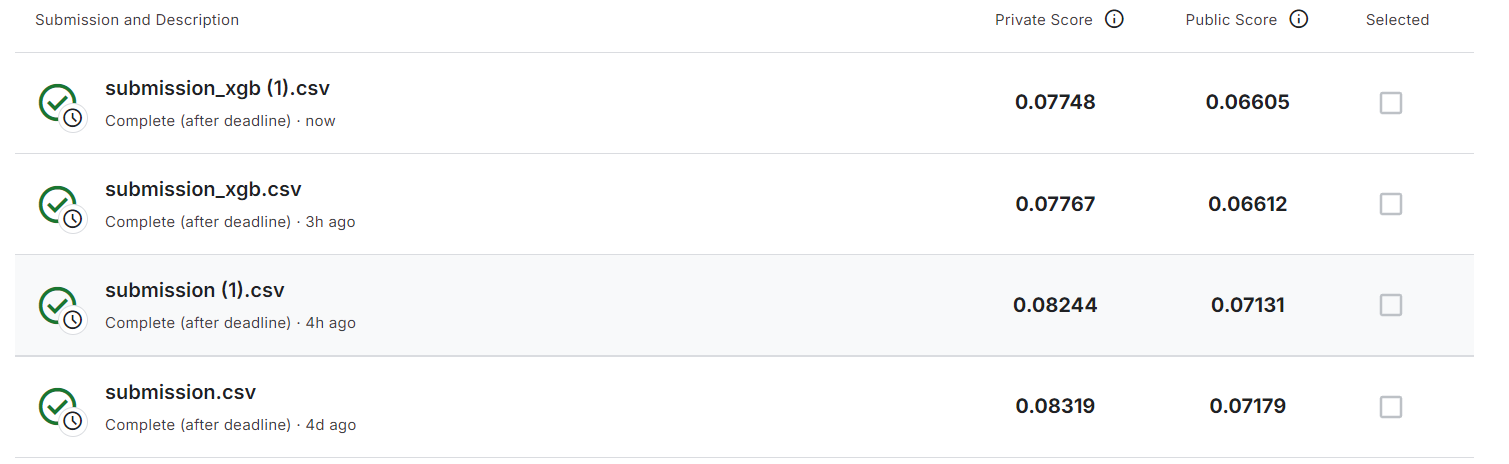

From bottom up.
Random Forest (most generic easy, I dropped almost all columns)
Random Forest with slightly better data augmentation
xgboost with best/current data augmentation
xgboost + my data on income

We can observe the score gets better in all cases which makes sense as I am hopefully making improvements to the data.

We have used random forest in previous homeworks so I will detail a bit what I learned about xgboost.

xgboost provides an open-source machine learning library that is implemented with gradient boosted trees. The trees are used to correct errors that are made in previous trees. I honestly have no idea how the gradient boosted trees work but it was easy to use after implemented and definitely outperformed the results from random forest.

An interesting result I noticed that I was happy with was the better results in submission. It was rewarding to see that some of the data augmentions I was performing was working and the difference in using xgboost compared to random forest was immense.

## **Q7: Permutation Test for Logerror Prediction Evaluation (15 Points)**


In [ ]:
from sklearn.metrics import mean_absolute_error
import random

def permutation_test(X_test, y_test, y_pred, num_permutations=100):
  original_metric = mean_absolute_error(y_test, y_pred)
  permuted_metrics = []

  for _ in range(num_permutations):
    # Permute y_test 100 times
    y_test_permuted = np.random.permutation(y_test)

    # Calculate the new mean absolute error and add it to our matrix
    permuted_metric = mean_absolute_error(y_test_permuted, y_pred)
    permuted_metrics.append(permuted_metric)

  # Calculate the p-value by taking the mean of the metrics
  print(permuted_metrics)
  permuted_metrics = np.array(permuted_metrics)
  p_value = np.mean(permuted_metrics <= original_metric)

  return original_metric, p_value

# For some reason, I can't get my explanation to be on the print pdf so I will put it here.
# Either my code is wrong or my model is pretty good. None of the permuted MAEs were less than my MAE.
# If my code is right, then this means my model is very accurate and much better than chance.
# This is surprising to me as I was expecting different results of a p value higher.

# I got
# [0.07227591386194243, 0.07214097906233731, 0.07215998528306494, 0.07215240954583702, 0.07221224888468421, 0.07212735746686902, 0.07214226458474919, 0.07202177879100992, 0.07208921951432938, 0.07224520987588948, 0.07232508895193497, 0.07209943679754871, 0.07200081709046131, 0.07211835624780512, 0.07207023537356712, 0.07211282710590643, 0.07203746366698802, 0.07234445259053307, 0.07205151207554517, 0.07209113062417509, 0.07209928358568189, 0.07222568524144918, 0.07228082323021498, 0.07204889327625906, 0.07227422325382979, 0.07218101029194722, 0.07216677331106287, 0.0720907965166368, 0.0723344649709925, 0.07220684127011061, 0.0721363942640794, 0.07213714806219959, 0.07230709503189968, 0.07230003371191411, 0.07239068282295384, 0.07209460898499047, 0.07218731908098432, 0.07209559351846431, 0.07222607892517947, 0.07203724309631564, 0.07239639574977007, 0.07245339089796601, 0.07214343450577454, 0.07206921075514257, 0.07231596680552582, 0.07219838921576877, 0.07230351172264322, 0.07212163459046057, 0.07219747281405511, 0.07227617554894072, 0.0720178210590737, 0.07226812009026085, 0.07211283414320938, 0.07207630143144278, 0.07212803689797383, 0.07226076679270199, 0.0721286201006392, 0.07232223079441374, 0.07216818902113349, 0.07228606854880151, 0.07229379810476333, 0.07256200628061212, 0.072304837784912, 0.07228138624774413, 0.0723189700965787, 0.07232767020132465, 0.07224114133863677, 0.07212481916208935, 0.07208496818959617, 0.072171376907851, 0.07216081661566273, 0.07207917694536983, 0.07232953383759994, 0.07200196522154566, 0.07227090655597525, 0.0721467577203768, 0.07233181182284265, 0.07186396893872957, 0.07212236017393339, 0.0721305851460336, 0.07230478878796938, 0.0721524631321866, 0.07211853749333615, 0.07212253146342029, 0.07216117037489657, 0.07219586043473127, 0.07223269045838845, 0.07224098817027254, 0.07211852452820576, 0.0720247676593487, 0.07226818521941791, 0.07221456035718132, 0.07219758040244882, 0.07193893686592183, 0.07230245977181145, 0.07199793284769114, 0.0721827841484572, 0.07216613261520825, 0.07217031784428724, 0.07222839404224525]
# Original MAE: 0.06931686973280192
# P-value: 0.0

original_mae, p_value = permutation_test(X_test, y_test, y_pred, num_permutations=100)

print(f"Original MAE: {original_mae}")
print(f"P-value: {p_value}")


[0.07227591386194243, 0.07214097906233731, 0.07215998528306494, 0.07215240954583702, 0.07221224888468421, 0.07212735746686902, 0.07214226458474919, 0.07202177879100992, 0.07208921951432938, 0.07224520987588948, 0.07232508895193497, 0.07209943679754871, 0.07200081709046131, 0.07211835624780512, 0.07207023537356712, 0.07211282710590643, 0.07203746366698802, 0.07234445259053307, 0.07205151207554517, 0.07209113062417509, 0.07209928358568189, 0.07222568524144918, 0.07228082323021498, 0.07204889327625906, 0.07227422325382979, 0.07218101029194722, 0.07216677331106287, 0.0720907965166368, 0.0723344649709925, 0.07220684127011061, 0.0721363942640794, 0.07213714806219959, 0.07230709503189968, 0.07230003371191411, 0.07239068282295384, 0.07209460898499047, 0.07218731908098432, 0.07209559351846431, 0.07222607892517947, 0.07203724309631564, 0.07239639574977007, 0.07245339089796601, 0.07214343450577454, 0.07206921075514257, 0.07231596680552582, 0.07219838921576877, 0.07230351172264322, 0.0721216345904

Either my code is wrong or my model is pretty good. None of the permuted MAEs were less than my MAE. If my code is right, then this means my model is very accurate and much better than chance. This is surprising to me as I was expecting different results of a p value higher.

f

## **Submission Guideline:**
- Submit everything through Google classroom. As mentioned above, you will need to upload:
  1. The Jupyter notebook all your work is in (.ipynb file), derived from the provided template
  2. PDF (export the notebook as a pdf file)


- These files should be named with the following format, where the italicized parts should be replaced with the corresponding values:
  1. cse519_hw2_*lastname_firstname_sbuid*.ipynb
  2. cse519_hw2_*lastname_firstname_sbuid*.pdf

Your Submission will  **NOT BE GRADED** if you don't follow the naming convention**❗❗**


Good Luck! (੭˶ᵔ ᵕ ᵔ˶)੭₊˚❀༉‧₊˚